# Pairwise MLP with PU

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- cone around the candidate trackster


## MLP

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from reco.loss import FocalLoss

from reco.datasetPU import TracksterPairsPU
from reco.training import precision_recall_curve, roc_auc


ds_name = "CloseByGamma200PUFull"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [30]:
ds = TracksterPairsPU(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=250,
    radius=10
)

ds.x.shape
ds.processed_file_names

['TracksterPairsPU_CloseByGamma200PUFull_f250_r10_s0.2.pt']

In [31]:
# scaler = StandardScaler()
# scaler.fit(ds.x)
# ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [32]:
print(ds.x.shape)

print("Positive:", int((ds.y > 0.7).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.7).type(torch.int).sum()))

torch.Size([45696, 43])
Positive: 4575
Negative: 41121


In [33]:
balance =  float(sum(ds.y > 0.7) / len(ds.y))
print(f"dataset balance: {balance*100:.2f}% / {(1-balance)*100:.2f}%") 

dataset balance: 10.01% / 89.99%


In [34]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 41127, Test samples: 4569


In [23]:
def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

In [24]:
hdim1 = 256
hdim2 = 128

model = nn.Sequential(
    nn.BatchNorm1d(ds.x.shape[1], affine=False),      # normalization as a part of the network
    nn.Linear(ds.x.shape[1], hdim1),
    nn.ReLU(),
    nn.Linear(hdim1, hdim2),
    nn.ReLU(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
)
model = model.to(device)
epochs = 101
model_path = f"models/PairWiseMLP.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"

In [25]:
#%%script echo skipping

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)
loss_obj = FocalLoss(alpha=1-balance, gamma=2)

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    test_auc = roc_auc(model, device, test_dl)
    scheduler.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, test auc: {test_auc:.4f}')

torch.save(model.state_dict(), model_path)

Epoch: 0, loss: 4.4516, train auc: 0.9701, test auc: 0.9690
Epoch: 10, loss: 3.7575, train auc: 0.9795, test auc: 0.9784
Epoch: 20, loss: 3.6956, train auc: 0.9817, test auc: 0.9786
Epoch: 30, loss: 3.6975, train auc: 0.9835, test auc: 0.9770
Epoch: 40, loss: 3.6612, train auc: 0.9854, test auc: 0.9719
Epoch: 50, loss: 3.5775, train auc: 0.9873, test auc: 0.9727
Epoch: 60, loss: 3.5779, train auc: 0.9884, test auc: 0.9735
Epoch: 70, loss: 3.4912, train auc: 0.9891, test auc: 0.9700
Epoch: 80, loss: 3.4932, train auc: 0.9904, test auc: 0.9710
Epoch: 90, loss: 3.4764, train auc: 0.9915, test auc: 0.9703
Epoch: 100, loss: 3.4772, train auc: 0.9915, test auc: 0.9715


In [26]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


In [35]:
roc_auc(model, device, test_dl)

0.9821869702107048

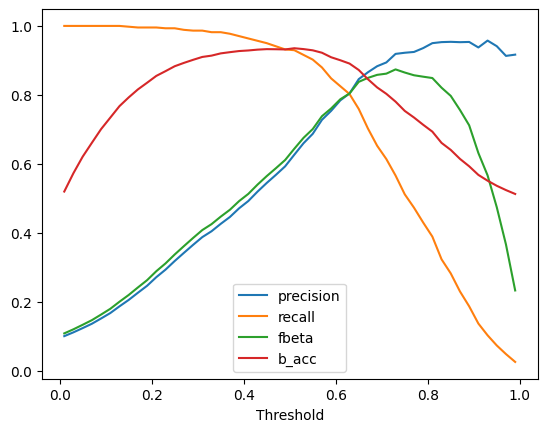

TP: 249, TN: 4107, FP: 22, FN: 191
TH: 0.73 precision: 0.919 recall: 0.566 fbeta: 0.874 b_acc: 0.780


In [37]:
# weirdly, training with larger radius makes it generalize better
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.3, step=2)

## Results

- hdim: (256, 128), roc_auc = 0.9956
- hdim: (512, 512), roc_auc = 0.9605 (overfit?) (test auc going down)
- hdim: (256, 256), alpha=1-balance, roc_auc = 0.9635 (overfit?) (test auc going down)


# ONNX export

In [128]:
import torch.onnx

onnx_filepath = f"models/PairWiseMLP.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.onnx"

In [129]:
torch.onnx.export(
    model,                      # model to be exported
    ds[0][0].reshape(1, -1),    # example input (add batch dimension)
    onnx_filepath,
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=['input'],      # the model's input names
    output_names=['output'],    # the model's output names
    dynamic_axes={              # variable length axes
        'input' : {0 : 'batch_size'},    
        'output' : {0 : 'batch_size'}
    }
)

In [130]:
import numpy as np
import onnxruntime

ort_session = onnxruntime.InferenceSession(onnx_filepath)

In [131]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [132]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(ds[:16][0])}
ort_outs = ort_session.run(None, ort_inputs)

In [133]:
torch_out = model(ds[:16][0])
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
